In [1]:
import torch as pt


mols_test = pt.load('./data/mine/test_11499.pt')
print(len(mols_test))
mols_all = pt.load('./data/mine/mols_all.pt')
print(len(mols_all))

11499
2253216


In [2]:
# 统计词频
import numpy as np


mols_train = mols_all[:232826]
count_list = np.zeros(1000)
for mol in mols_train:
    tmp_list = np.zeros(1000)
    for mz in mol.mz:
        tmp_list[int(mz)] = 1
    count_list += tmp_list

count_list += 1  
print(count_list.shape)

(1000,)


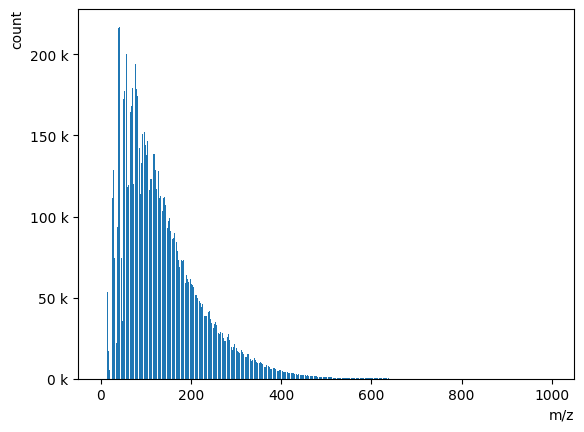

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fig = plt.figure()
ax = fig.add_subplot()
ax.bar(np.arange(1000), count_list)
ax.set_xlabel('m/z', loc='right')
ax.set_ylabel('count', loc='top')
# ax.legend()
def formatter(x, pos):
    return f'{int(x/1000)} k'
plt.gca().yaxis.set_major_formatter(FuncFormatter(formatter))
# fig.savefig('count_bar.svg', format='svg', dpi=500)

In [4]:
import numpy as np


# 生成负采样概率
pow_frequency = np.array(count_list) ** 0.75
neg_prob = pow_frequency / pow_frequency.sum()
print(neg_prob.shape)
# 生成下采样概率
mzs_freq = np.array(count_list)
mzs_freq = mzs_freq / np.sum(mzs_freq)
t = 1e-3
keep_prob = np.array([np.sqrt(t/f) + t/f for f in mzs_freq])

(1000,)


In [5]:
from torch.utils.data import DataLoader
from utils.data import SpecDataset, collate_fun, collate_fun_emb
import numpy as np


dataset_lib = SpecDataset(mols_all)
dataset_test = SpecDataset(mols_test)
loader_lib = DataLoader(dataset_lib, batch_size=2048, shuffle=False,
                        num_workers=8, collate_fn=collate_fun_emb)
loader_test = DataLoader(dataset_test, batch_size=2048, shuffle=False,
                        num_workers=8, collate_fn=collate_fun_emb)
dataset_train = SpecDataset(dataset_lib, mapping=np.arange(232826))
loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, 
                            num_workers=8, collate_fn=collate_fun(keep_prob, neg_prob))
num_batches = len(loader_train)

In [6]:
import torch.optim as optim
from utils.model import Spec2Emb, Linear_Scheduler


gpu = 8
model = Spec2Emb().to(gpu)

epochs = 10
lr = 0.025
optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = Linear_Scheduler(optimizer, epochs, start_lr=lr, end_lr=2.5e-4)

In [7]:
from tqdm import tqdm
from utils.tools import gen_embeddings, build_idx, evaluate, save_model



f = open('base_log.txt', 'w')
model_name = 'base_log'
max_metrics = {'expand': [0, 0], 'insilico': [0, 0]}
for epoch in range(epochs):
    print(f'==================================Train_epoch{epoch+1}======================================')
    model.train()
    train_loss = []
    for i, Data in enumerate(tqdm(loader_train, unit='batch')):
        data = [d.to(gpu) for d in Data]
        optimizer.zero_grad()
        loss = model(data)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        batch_progress = (i+1)/num_batches
        lr = scheduler.lr_lambda(epoch, batch_progress)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        if (i+1) %1000 ==0:
            loss = np.mean(train_loss)
            print(f'Total Loss: {loss}')
            train_loss = []
    
    print(f'===================================Test_epoch{epoch+1}======================================')
    f.write('\nTest_epoch%d\n' % (epoch+1))
    embeddings_lib = gen_embeddings(model, loader_lib, gpu)
    embeddings_test = gen_embeddings(model, loader_test, gpu)
    I_expand, _ = build_idx(embeddings_lib, embeddings_test, gpu)
    top1_expand, top10_expand = evaluate(mols_test, I_expand, mols_all, f, 'Expanded')
    if top1_expand > max_metrics['expand'][0] and top10_expand > max_metrics['expand'][1]:
        max_metrics['expand'] = [top1_expand, top10_expand]
        save_model(model, model_name, epoch)
    I_insilico, _ = build_idx(embeddings_lib[:2146690], embeddings_test, gpu)
    top1_insilico, top10_insilico = evaluate(mols_test, I_insilico, mols_all, f, 'In-silico')
    if top1_insilico > max_metrics['insilico'][0] and top10_insilico > max_metrics['insilico'][1]:
        max_metrics['insilico'] = [top1_insilico, top10_insilico]
        save_model(model, model_name, epoch)
    print(f'================================================================================================')
f.close()

==================================Train_epoch1======================================


 14%|█▍        | 1007/7276 [00:21<01:45, 59.18batch/s]

Total Loss: 6089.370430419922


 28%|██▊       | 2008/7276 [00:39<01:30, 58.26batch/s]

Total Loss: 5103.969547851562


 41%|████▏     | 3005/7276 [00:56<01:10, 60.45batch/s]

Total Loss: 4957.171198974609


 55%|█████▌    | 4007/7276 [01:14<00:56, 57.93batch/s]

Total Loss: 4844.542383056641


 69%|██████▉   | 5010/7276 [01:32<00:44, 51.25batch/s]

Total Loss: 4747.507932617187


 83%|████████▎ | 6006/7276 [01:49<00:21, 59.79batch/s]

Total Loss: 4747.070338867187


 96%|█████████▋| 7011/7276 [02:06<00:04, 56.19batch/s]

Total Loss: 4665.448889404297


100%|██████████| 7276/7276 [02:12<00:00, 55.00batch/s]

===================================Test_epoch1======================================


Searching time:  0:00:01.621589
Expanded library
Top1 hit rate: 15.55%
Top10 hit rate: 46.84%
Searching time:  0:00:01.525611
In-silico library
Top1 hit rate: 15.76%
Top10 hit rate: 47.19%
==================================Train_epoch2======================================


 14%|█▍        | 1008/7276 [00:22<01:56, 53.59batch/s]

Total Loss: 4678.184623535156


 28%|██▊       | 2006/7276 [00:39<01:39, 52.94batch/s]

Total Loss: 4630.853333251953


 41%|████▏     | 3010/7276 [00:57<01:14, 57.62batch/s]

Total Loss: 4628.0421806640625


 55%|█████▌    | 4007/7276 [01:15<00:55, 59.21batch/s]

Total Loss: 4582.800409667969


 69%|██████▉   | 5010/7276 [01:32<00:38, 59.05batch/s]

Total Loss: 4592.596938720703


 83%|████████▎ | 6006/7276 [01:49<00:20, 63.40batch/s]

Total Loss: 4568.669753173828


 96%|█████████▋| 7011/7276 [02:07<00:04, 64.43batch/s]

Total Loss: 4593.734506103516


100%|██████████| 7276/7276 [02:13<00:00, 54.57batch/s]

===================================Test_epoch2======================================


Searching time:  0:00:01.594851
Expanded library
Top1 hit rate: 15.63%
Top10 hit rate: 47.46%
Searching time:  0:00:01.515233
In-silico library
Top1 hit rate: 15.84%
Top10 hit rate: 47.76%
==================================Train_epoch3======================================


 14%|█▍        | 1009/7276 [00:20<01:48, 57.64batch/s]

Total Loss: 4556.576239257813


 28%|██▊       | 2010/7276 [00:38<01:29, 58.99batch/s]

Total Loss: 4537.927028564453


 41%|████▏     | 3008/7276 [00:58<01:27, 48.84batch/s]

Total Loss: 4531.810795654297


 55%|█████▌    | 4008/7276 [01:19<00:55, 58.51batch/s]

Total Loss: 4545.492762207031


 69%|██████▉   | 5008/7276 [01:36<00:40, 56.00batch/s]

Total Loss: 4532.93124584961


 83%|████████▎ | 6012/7276 [01:54<00:20, 61.39batch/s]

Total Loss: 4511.519889892578


 96%|█████████▋| 7006/7276 [02:11<00:04, 56.50batch/s]

Total Loss: 4513.974603027344


100%|██████████| 7276/7276 [02:17<00:00, 52.95batch/s]

===================================Test_epoch3======================================


Searching time:  0:00:01.673684
Expanded library
Top1 hit rate: 15.76%
Top10 hit rate: 47.57%
Searching time:  0:00:01.597630
In-silico library
Top1 hit rate: 15.98%
Top10 hit rate: 47.98%
==================================Train_epoch4======================================


 14%|█▍        | 1006/7276 [00:22<01:43, 60.58batch/s]

Total Loss: 4496.196471679687


 28%|██▊       | 2008/7276 [00:39<01:31, 57.74batch/s]

Total Loss: 4499.4114816894535


 41%|████▏     | 3007/7276 [00:56<01:05, 65.10batch/s]

Total Loss: 4497.305567871093


 55%|█████▌    | 4007/7276 [01:14<00:59, 55.12batch/s]

Total Loss: 4500.280263916015


 69%|██████▉   | 5006/7276 [01:31<00:36, 61.69batch/s]

Total Loss: 4491.761201904297


 83%|████████▎ | 6009/7276 [01:48<00:24, 51.89batch/s]

Total Loss: 4469.273024902343


 96%|█████████▋| 7010/7276 [02:07<00:04, 62.73batch/s]

Total Loss: 4482.836567626953


100%|██████████| 7276/7276 [02:13<00:00, 54.49batch/s]

===================================Test_epoch4======================================


Searching time:  0:00:01.604782
Expanded library
Top1 hit rate: 15.97%
Top10 hit rate: 47.53%
Searching time:  0:00:01.608993
In-silico library
Top1 hit rate: 16.18%
Top10 hit rate: 47.93%
==================================Train_epoch5======================================


 14%|█▍        | 1012/7276 [00:21<01:45, 59.15batch/s]

Total Loss: 4462.0601286621095


 28%|██▊       | 2009/7276 [00:38<01:28, 59.21batch/s]

Total Loss: 4484.607411132813


 41%|████▏     | 3008/7276 [00:56<01:11, 59.73batch/s]

Total Loss: 4471.8520485839845


 55%|█████▌    | 4005/7276 [01:12<00:54, 60.16batch/s]

Total Loss: 4447.1296755371095


 69%|██████▉   | 5008/7276 [01:29<00:38, 59.42batch/s]

Total Loss: 4444.9321953125


 83%|████████▎ | 6006/7276 [01:45<00:21, 60.41batch/s]

Total Loss: 4433.793981933593


 96%|█████████▋| 7012/7276 [02:02<00:04, 61.60batch/s]

Total Loss: 4457.10842553711


100%|██████████| 7276/7276 [02:07<00:00, 56.89batch/s]

===================================Test_epoch5======================================


Searching time:  0:00:01.594903
Expanded library
Top1 hit rate: 15.85%
Top10 hit rate: 47.66%
Searching time:  0:00:01.527984
In-silico library
Top1 hit rate: 16.07%
Top10 hit rate: 48.00%
==================================Train_epoch6======================================


 14%|█▍        | 1009/7276 [00:20<01:33, 66.87batch/s]

Total Loss: 4441.345623535156


 28%|██▊       | 2011/7276 [00:37<01:25, 61.29batch/s]

Total Loss: 4439.828406738281


 41%|████▏     | 3007/7276 [00:54<01:20, 53.05batch/s]

Total Loss: 4421.05617944336


 55%|█████▌    | 4008/7276 [01:12<01:02, 52.06batch/s]

Total Loss: 4430.0167453613285


 69%|██████▉   | 5006/7276 [01:29<00:37, 60.72batch/s]

Total Loss: 4425.186439697266


 83%|████████▎ | 6009/7276 [01:46<00:22, 56.15batch/s]

Total Loss: 4425.766387939453


 96%|█████████▋| 7009/7276 [02:02<00:04, 62.05batch/s]

Total Loss: 4408.409954833985


100%|██████████| 7276/7276 [02:08<00:00, 56.84batch/s]

===================================Test_epoch6======================================


Searching time:  0:00:01.598154
Expanded library
Top1 hit rate: 16.04%
Top10 hit rate: 47.84%
Searching time:  0:00:01.517527
In-silico library
Top1 hit rate: 16.24%
Top10 hit rate: 48.17%
==================================Train_epoch7======================================


 14%|█▍        | 1009/7276 [00:20<01:42, 61.42batch/s]

Total Loss: 4408.038583007812


 28%|██▊       | 2007/7276 [00:36<01:25, 61.79batch/s]

Total Loss: 4392.315282226563


 41%|████▏     | 3008/7276 [00:53<01:20, 52.93batch/s]

Total Loss: 4395.701947753906


 55%|█████▌    | 4011/7276 [01:09<00:51, 63.05batch/s]

Total Loss: 4417.090203369141


 69%|██████▉   | 5009/7276 [01:26<00:39, 57.64batch/s]

Total Loss: 4384.583829833984


 83%|████████▎ | 6009/7276 [01:43<00:20, 62.19batch/s]

Total Loss: 4409.755079345703


 96%|█████████▋| 7011/7276 [02:00<00:05, 50.04batch/s]

Total Loss: 4394.834260742187


100%|██████████| 7276/7276 [02:05<00:00, 57.80batch/s]

===================================Test_epoch7======================================


Searching time:  0:00:01.612750
Expanded library
Top1 hit rate: 16.00%
Top10 hit rate: 47.80%
Searching time:  0:00:01.527824
In-silico library
Top1 hit rate: 16.20%
Top10 hit rate: 48.19%
==================================Train_epoch8======================================


 14%|█▍        | 1007/7276 [00:20<01:46, 59.09batch/s]

Total Loss: 4395.5543068847655


 28%|██▊       | 2007/7276 [00:36<01:28, 59.32batch/s]

Total Loss: 4390.239142578125


 41%|████▏     | 3010/7276 [00:53<01:27, 48.89batch/s]

Total Loss: 4361.707003417969


 55%|█████▌    | 4010/7276 [01:10<00:51, 63.08batch/s]

Total Loss: 4357.913639892578


 69%|██████▉   | 5005/7276 [01:26<00:39, 57.62batch/s]

Total Loss: 4368.652230224609


 83%|████████▎ | 6009/7276 [01:43<00:21, 58.44batch/s]

Total Loss: 4368.910157226563


 96%|█████████▋| 7008/7276 [02:00<00:04, 65.71batch/s]

Total Loss: 4401.783680175781


100%|██████████| 7276/7276 [02:05<00:00, 58.15batch/s]

===================================Test_epoch8======================================


Searching time:  0:00:01.598548
Expanded library
Top1 hit rate: 16.05%
Top10 hit rate: 47.89%
Searching time:  0:00:01.524510
In-silico library
Top1 hit rate: 16.26%
Top10 hit rate: 48.25%
==================================Train_epoch9======================================


 14%|█▍        | 1012/7276 [00:21<01:42, 61.30batch/s]

Total Loss: 4377.277568115234


 28%|██▊       | 2008/7276 [00:37<01:32, 56.94batch/s]

Total Loss: 4351.2149831542965


 41%|████▏     | 3010/7276 [00:54<01:09, 61.57batch/s]

Total Loss: 4356.958926269531


 55%|█████▌    | 4011/7276 [01:11<00:56, 57.43batch/s]

Total Loss: 4351.106186279297


 69%|██████▉   | 5011/7276 [01:28<00:38, 59.36batch/s]

Total Loss: 4340.708814453125


 83%|████████▎ | 6007/7276 [01:44<00:21, 58.85batch/s]

Total Loss: 4354.602824462891


 96%|█████████▋| 7007/7276 [02:01<00:04, 56.67batch/s]

Total Loss: 4347.352869873047


100%|██████████| 7276/7276 [02:06<00:00, 57.40batch/s]

===================================Test_epoch9======================================


Searching time:  0:00:01.586156
Expanded library
Top1 hit rate: 16.18%
Top10 hit rate: 47.92%
Searching time:  0:00:01.511247
In-silico library
Top1 hit rate: 16.39%
Top10 hit rate: 48.31%
==================================Train_epoch10======================================


 14%|█▍        | 1009/7276 [00:19<01:34, 66.32batch/s]

Total Loss: 4327.11515258789


 28%|██▊       | 2010/7276 [00:37<01:27, 59.91batch/s]

Total Loss: 4348.519002685547


 41%|████▏     | 3010/7276 [00:54<01:13, 58.15batch/s]

Total Loss: 4321.942749755859


 55%|█████▌    | 4006/7276 [01:12<00:55, 59.42batch/s]

Total Loss: 4347.477515625


 69%|██████▉   | 5008/7276 [01:29<00:37, 61.16batch/s]

Total Loss: 4340.5745625


 83%|████████▎ | 6006/7276 [01:45<00:21, 58.24batch/s]

Total Loss: 4339.7718303222655


 96%|█████████▋| 7007/7276 [02:02<00:04, 56.11batch/s]

Total Loss: 4316.208511962891


100%|██████████| 7276/7276 [02:07<00:00, 57.08batch/s]

===================================Test_epoch10======================================


Searching time:  0:00:01.593755
Expanded library
Top1 hit rate: 16.14%
Top10 hit rate: 47.92%
Searching time:  0:00:01.510266
In-silico library
Top1 hit rate: 16.34%
Top10 hit rate: 48.30%


In [7]:
pt.cuda.empty_cache()